In [4]:
# 1. Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

# Optional: for profiling
# from pandas_profiling import ProfileReport


In [5]:
# 2. Load Data


df = pd.read_csv('../data/heart-disease.csv')
print("Original shape:", df.shape)
df.head()


Original shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
# 3. Initial Data Inspection


df.info()
df.describe(include='all').T

# No missing values, but we will simulate a scenario to demonstrate imputation.
# We'll artificially introduce missing values in 'chol' for demonstration (then impute).
# %%
# Create a copy for demonstration
df_demo = df.copy()
np.random.seed(42)
missing_idx = np.random.choice(df_demo.index, size=20, replace=False)
df_demo.loc[missing_idx, 'chol'] = np.nan
print("Missing values introduced:\n", df_demo.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
Missing values introduced:
 age          0
sex          0
cp           0
trestbps     0
chol        20
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal       

In [7]:
# 4. Advanced Imputation (KNNImputer) 

# 
# We'll use KNN imputer to fill missing cholesterol values.

# %%
# Separate features for imputation
features_for_impute = ['age', 'sex', 'trestbps', 'chol', 'thalach', 'oldpeak']
imputer = KNNImputer(n_neighbors=5)
df_demo[features_for_impute] = imputer.fit_transform(df_demo[features_for_impute])
print("Missing after imputation:\n", df_demo.isnull().sum())

# Replace original df with imputed version
df = df_demo.copy()



Missing after imputation:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Outlier counts:
 iso_outlier        31
dbscan_outlier    303
ae_outlier         31
outlier_any       303
dtype: int64


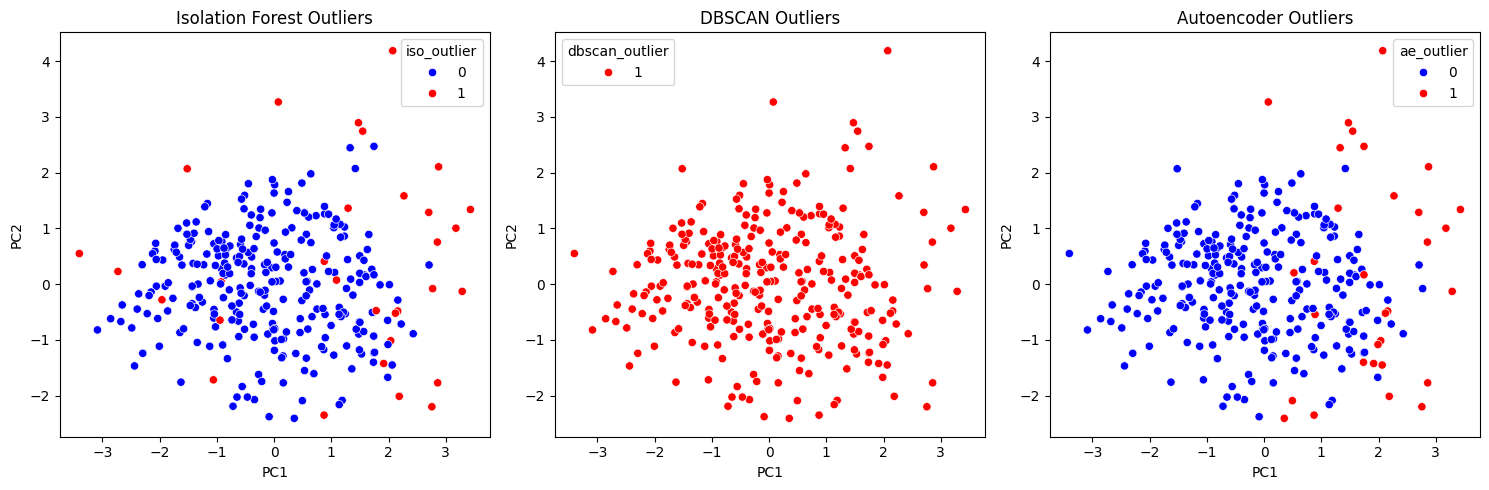

In [8]:
# 5. Outlier Detection and Treatment 

# We'll apply three methods: Isolation Forest, DBSCAN, and Autoencoder reconstruction error.


# Scale continuous features for outlier detection
continuous_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
scaler = StandardScaler()
scaled_cont = scaler.fit_transform(df[continuous_cols])

# ---- Isolation Forest ----
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_labels = iso_forest.fit_predict(scaled_cont)
df['iso_outlier'] = (iso_labels == -1).astype(int)

# ---- DBSCAN ----
dbscan = DBSCAN(eps=0.5, min_samples=5)
db_labels = dbscan.fit_predict(scaled_cont)
df['dbscan_outlier'] = (db_labels == -1).astype(int)

# ---- Autoencoder for Anomaly Detection ----
# Build a simple autoencoder
input_dim = len(continuous_cols)
encoding_dim = 3

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='linear')(encoded)
autoencoder = keras.Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train on normal data only? But we don't know which are normal. We'll train on all and use reconstruction error as outlier score.
history = autoencoder.fit(scaled_cont, scaled_cont, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Reconstruction error
reconstructions = autoencoder.predict(scaled_cont)
mse = np.mean(np.square(scaled_cont - reconstructions), axis=1)
threshold = np.percentile(mse, 90)  # top 10% as outliers
df['ae_outlier'] = (mse > threshold).astype(int)

# Combine outlier flags (if any method flags, consider outlier)
df['outlier_any'] = (df['iso_outlier'] | df['dbscan_outlier'] | df['ae_outlier']).astype(int)
print("Outlier counts:\n", df[['iso_outlier', 'dbscan_outlier', 'ae_outlier', 'outlier_any']].sum())

# Visualize outliers on PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_cont)
df['PC1'] = pca_result[:,0]
df['PC2'] = pca_result[:,1]

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.scatterplot(x='PC1', y='PC2', hue='iso_outlier', data=df, palette={0:'blue',1:'red'})
plt.title('Isolation Forest Outliers')
plt.subplot(1,3,2)
sns.scatterplot(x='PC1', y='PC2', hue='dbscan_outlier', data=df, palette={0:'blue',1:'red'})
plt.title('DBSCAN Outliers')
plt.subplot(1,3,3)
sns.scatterplot(x='PC1', y='PC2', hue='ae_outlier', data=df, palette={0:'blue',1:'red'})
plt.title('Autoencoder Outliers')
plt.tight_layout()
plt.show()


In [9]:
# 6. Feature Engineering
# 
# Create new features to capture interactions and non-linearities.

# %%
# Age groups
df['age_group'] = pd.cut(df['age'], bins=[29,40,50,60,80], labels=['30s','40s','50s','60+'])

# Cholesterol to blood pressure ratio (potential risk factor)
df['chol_trestbps_ratio'] = df['chol'] / df['trestbps']

# Heart rate reserve? Not exactly.
# Interaction: age * oldpeak
df['age_oldpeak'] = df['age'] * df['oldpeak']

# Polynomial features (select few)
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly_features = poly.fit_transform(df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']])
poly_feature_names = poly.get_feature_names_out(['age', 'trestbps', 'chol', 'thalach', 'oldpeak'])
df_poly = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)

# Select only interaction terms (to avoid too many features)
interaction_terms = [col for col in df_poly.columns if ' ' in col and '^' not in col]
df = pd.concat([df, df_poly[interaction_terms]], axis=1)

print("Shape after feature engineering:", df.shape)

Shape after feature engineering: (303, 33)


In [ ]:
# 7. Data Type Correction and Consistency


# Convert categorical columns to category
categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target', 'age_group']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Check for illogical values: e.g., trestbps should be > 0, etc. All fine.

In [10]:
# 8. Save Cleaned Dataset


df.to_csv('heart_disease_cleaned_advanced.csv', index=False)
print("Advanced cleaned dataset saved.")

Advanced cleaned dataset saved.
